In [1]:
import os

import numpy as np

from dynamic_programming.mdp_model import MDPModel
from envs.env_creator import env_creator
from base_algorithm.eval_policy import EvalDiscreteStatePolicy
import time
import pandas as pd
from rmin.train import RMinTrainer
from dynamic_programming.policy import DPPolicy

## Load Data and MDP Model

In [2]:
device = 'cpu'
load_path = os.path.join("tmp", "ibqf-out/ibq_samples.npy")
#load_path = os.path.join("tmp", "ibq_samples_50m.npy")
mdp_save_path = 'tmp/dynamic_programming/mdp_model.pkl'
sa_reward = True
samples = np.load(load_path, allow_pickle=True)[()]

print(samples['rewards'].mean())
print(samples['rewards'].size)
samples['rewards'] = samples['rewards'] + np.abs(samples['rewards'].min())
print(samples['rewards'].min())
print(np.unique(samples['obs']).size)

-313.560969726944
20000
0.0
815


## Compute MDP Model

In [3]:
start = time.time()
mdp_model = MDPModel(states=samples['obs'], next_states=samples['new_obs'], actions=samples['actions'],
                     rewards=samples['rewards'], dones=samples['dones'], device=device, sa_reward=sa_reward)

end = time.time()
print(end - start)

Computing Reward Function
Computing Transition Model
0.670729398727417


## Save MDP Model

In [4]:
mdp_model.save(mdp_save_path)

## Load MDP Model

In [3]:
mdp_model = MDPModel.load(mdp_save_path)

## Train

Epoch: 12


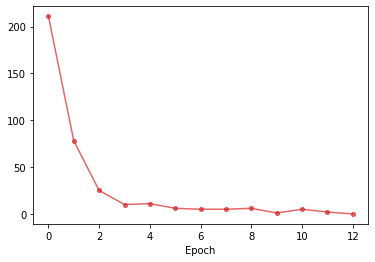

In [11]:

solver = RMinTrainer(reward_function=mdp_model.reward_function, transition_model=mdp_model.transition_model,
                     count_state_action=mdp_model.count_state_action, min_count=3)
solver.train(epochs=50000, gamma=0.99)
policy_save_path = 'tmp/rmin/ib_policy.pkl'

trained_policy = DPPolicy(policy_table=solver.get_policy(), state_to_index=mdp_model.state_to_index,
                          index_to_action=mdp_model.index_to_actions)
trained_policy.save(policy_save_path)

In [12]:
solver.get_policy()

array([ 0,  0,  0,  0,  0,  0,  0, 24,  0,  0,  0, 13,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14,  0,  0,  0,  0, 23,
        0,  0,  0,  0,  0,  0,  0, 23,  0,  0,  0,  0,  0, 12, 15,  0, 25,
        0, 15, 15,  5, 14,  0,  3,  0,  0,  0,  0,  0, 14, 13, 14,  0,  0,
       21, 22,  9,  0,  0,  0,  0, 14,  6,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  8,  8, 16,  0,  0,  0,  0, 11,  0,
        8, 17,  0,  9,  0, 17,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,
       14,  0,  0,  0,  0,  0,  0,  0, 23,  0,  0,  0,  0,  0, 21,  0,  0,
        0,  0,  0,  4, 21,  0,  0,  9,  0,  4,  0,  0,  0,  0,  0,  0,  0,
        0, 20, 10,  0,  0, 13,  0,  0,  0,  0,  0, 13,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  7,  0, 21,  0,  0,  0,  5,  6,  0,
        0, 25,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

## Evaluate

In [13]:


steps_per_episode = 1000
env_kwargs = {'steps_per_episode': steps_per_episode, 'device': device, 'config': None}

policy = DPPolicy.load(policy_save_path)
algo = EvalDiscreteStatePolicy(policy=policy, env_creator=env_creator, env_kwargs=env_kwargs)

Episode 9 Reward: -243.88907045773578 || New State Found: False


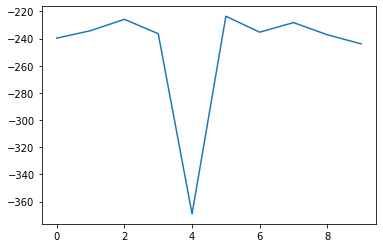

Reward Mean: -247.30685311547813
Reward std : 41.01528289489068


In [14]:
algo.evaluate(epochs=10)

In [8]:
algo.eval_new_state_found

[False, False, True, False, False, False, False, False, False, False]

In [22]:
df = pd.DataFrame(algo.eval_trajectories[0]['info'])
df.head()

,setpoint,velocity,gain,shift,fatigue,consumption,op_cost_t0,op_cost_t1,op_cost_t2,op_cost_t3,...,op_cost_t5,op_cost_t6,op_cost_t7,op_cost_t8,op_cost_t9,ml1,ml2,ml3,hv,hg
0,70,50.0,60.0,44.248466,20.194147,116.573918,104.584986,104.584986,104.584986,104.584986,...,104.584986,104.584986,104.584986,104.584986,134.289780,-1,1,-2.0,0.053730,0.062417
1,70,49.0,50.0,38.496931,23.661066,108.146667,104.584986,104.584986,104.584986,104.584986,...,104.584986,104.584986,104.584986,134.289780,100.484150,-1,1,-3.0,0.048711,0.080457
2,70,49.0,60.0,32.745397,22.294977,108.774739,104.584986,104.584986,104.584986,104.584986,...,104.584986,104.584986,134.289780,100.484150,129.024202,-1,1,-4.0,0.046408,0.124510
3,70,48.0,50.0,26.993863,34.267068,111.910362,104.584986,104.584986,104.584986,104.584986,...,104.584986,134.289780,100.484150,129.024202,96.544110,-1,1,-5.0,0.146049,0.129565
4,70,47.0,40.0,21.242328,30.020032,111.303077,104.584986,104.584986,104.584986,104.584986,...,134.289780,100.484150,129.024202,96.544110,72.240440,-1,-1,-6.0,0.133834,0.154014


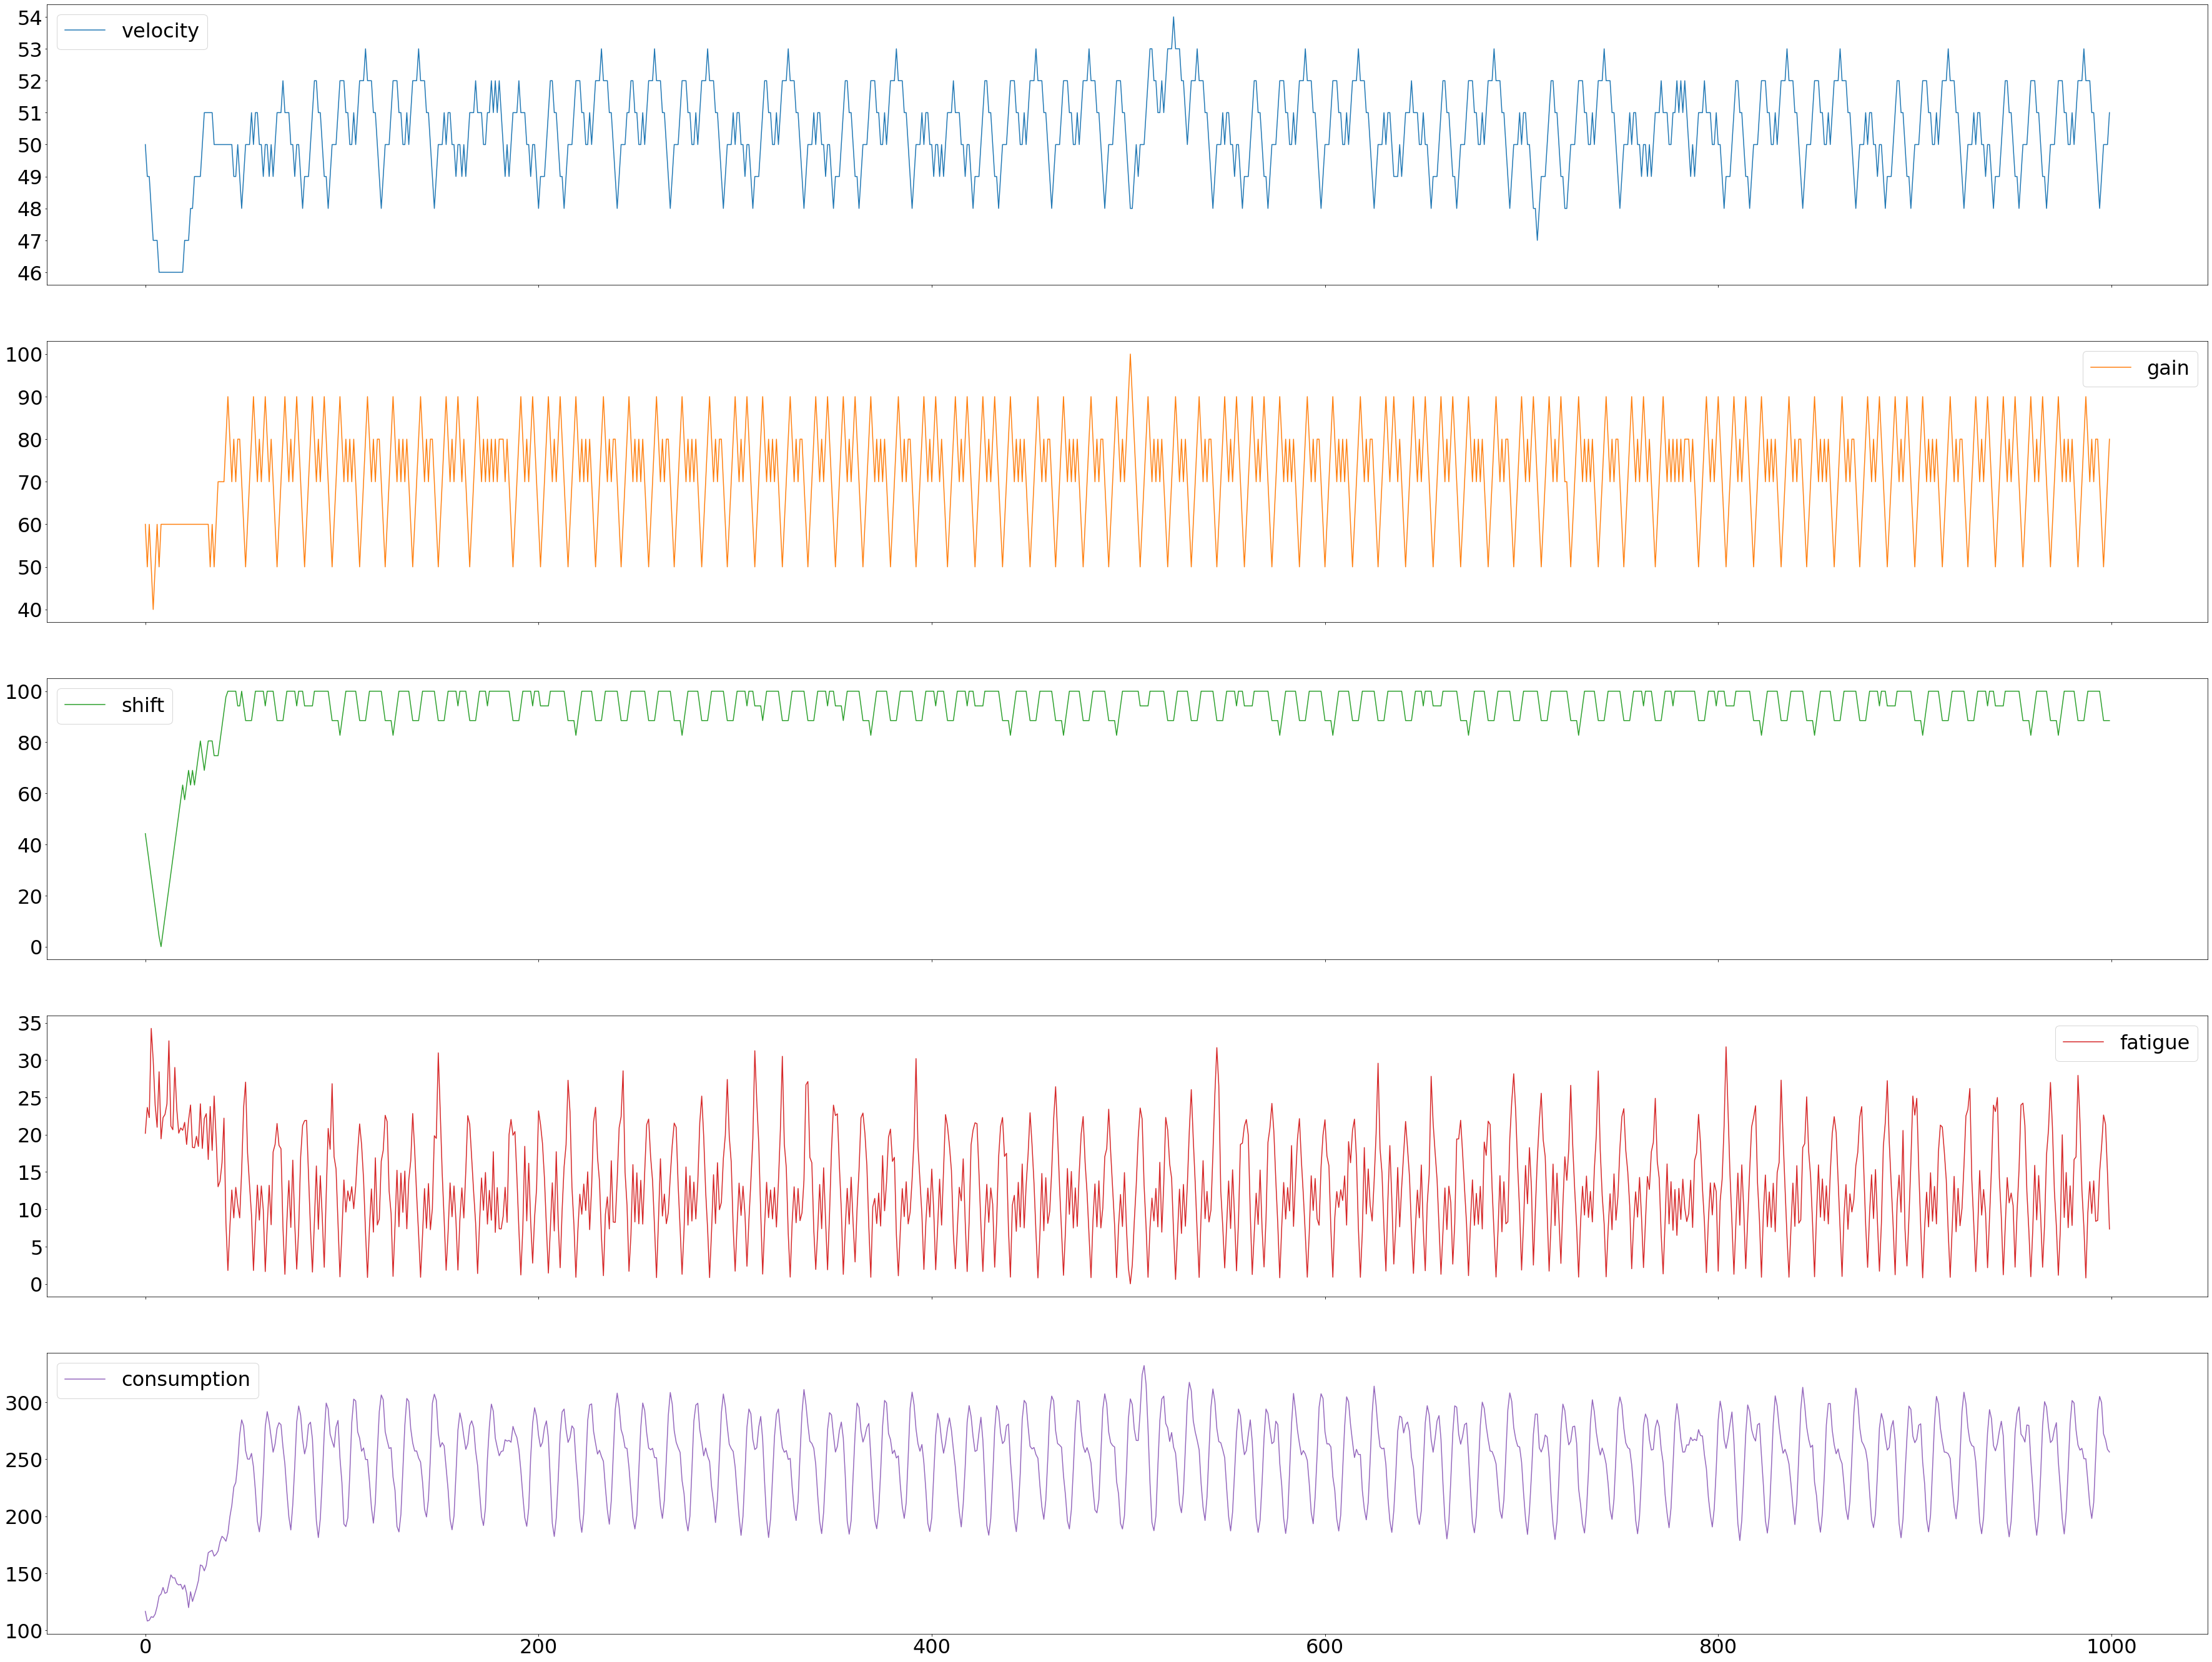

In [23]:
axes = df[['velocity', 'gain', 'shift', 'fatigue', 'consumption']].plot(subplots=True, figsize=(62, 48), fontsize=32)
for a in axes:
    a.legend(loc='best', prop={'size': 32})